In [1]:
import time
import copy
import cv2
import torch
import numpy as np
import imageio
import pickle as pkl
from PIL import Image
from IPython import display
from torchvision import datasets, transforms, models
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.Compose([transforms.Resize([256,256]),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

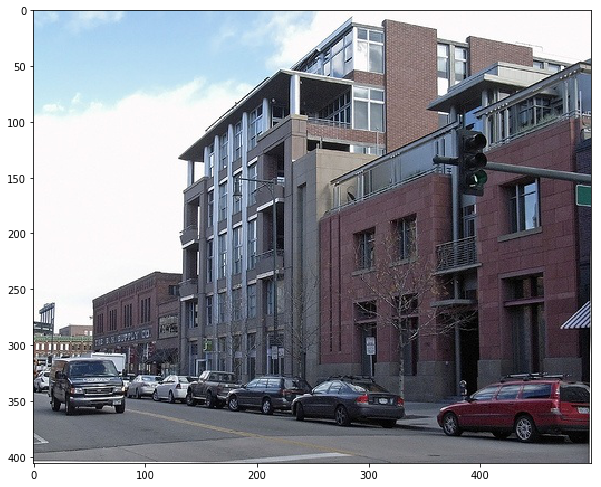

In [3]:
fname = 'img.jpg'
img = Image.open(fname)

plt.figure(figsize = (10, 10))
plt.imshow(img)

In [4]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
            
def sliding_gif(image, gif_fname, winW=128, winH=128, gif_scale=0.5):
    height, width, _ = image.shape
    width_gif = int(width * gif_scale)
    height_gif = int(height * gif_scale)

    images = []

    for (x, y, window) in sliding_window(image, stepSize=64, windowSize=(winW, winH)):
        # if the window does not meet our desired window size, ignore it
        if window.shape[0] != winH or window.shape[1] != winW:
            continue

        clone = image.copy()
        cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
        clone = cv2.resize(clone, (width_gif, height_gif))
        images.append(Image.fromarray(clone))

    imageio.mimwrite(gif_fname, images, duration=0.1)

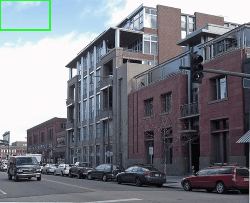

In [5]:
winW = 100
winH = 60

image = np.array(img)
fname = "sliding.gif"
sliding_gif(image, fname, winW=winW, winH=winH)
display.Image(filename=fname)

In [6]:
model = models.resnet18(pretrained=True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

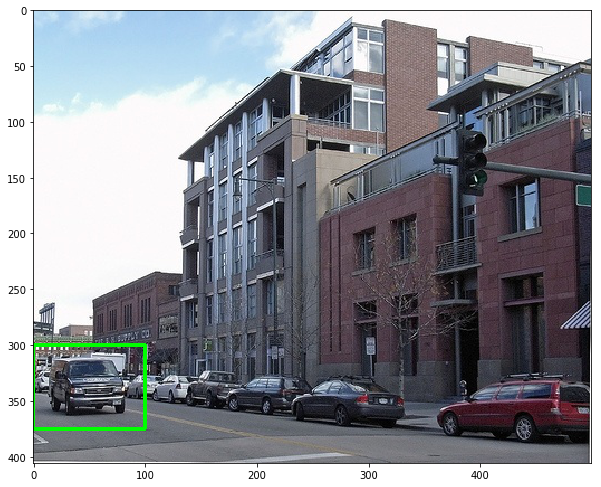

In [7]:
x1 = 0
x2 = 100
y1 = 300
y2 = 375

image = np.array(img)
clone = image.copy()
cv2.rectangle(clone, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.figure(figsize = (10, 10))
plt.imshow(clone)

In [8]:
cropped = image[y1:y2, x1:x2]
cropped = Image.fromarray(cropped)
cropped = transform(cropped).unsqueeze(0)
preds = model(cropped).detach().numpy()

k = 5
top_k = preds.argsort()[0][-k:][::-1]

with open('data/imagenet_dict.pkl', 'rb') as handle:
    imagenet_dict = pkl.load(handle)
    
for i, idx in enumerate(top_k):
    print(i + 1, imagenet_dict[idx])

1 moving van
2 trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi
3 garbage truck, dustcart
4 minivan
5 tow truck, tow car, wrecker


In [9]:
trans_cifar_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.Resize([256,256]),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

trans_cifar_val = transforms.Compose([transforms.Resize([256,256]),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset_train = datasets.CIFAR100('data/cifar100', train=True, download=True, transform=trans_cifar_train)
dataset_test = datasets.CIFAR100('data/cifar100', train=False, download=True, transform=trans_cifar_val)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
with open('data/cifar100/cifar-100-python/meta', 'rb') as handle:
    classes = pkl.load(handle)['fine_label_names']

class_to_idx = {}
idx_to_class = {}
for idx, class_name in enumerate(classes):
    class_to_idx[class_name] = idx
    idx_to_class[idx] = class_name
    
class_to_idx

{'apple': 0,
 'aquarium_fish': 1,
 'baby': 2,
 'bear': 3,
 'beaver': 4,
 'bed': 5,
 'bee': 6,
 'beetle': 7,
 'bicycle': 8,
 'bottle': 9,
 'bowl': 10,
 'boy': 11,
 'bridge': 12,
 'bus': 13,
 'butterfly': 14,
 'camel': 15,
 'can': 16,
 'castle': 17,
 'caterpillar': 18,
 'cattle': 19,
 'chair': 20,
 'chimpanzee': 21,
 'clock': 22,
 'cloud': 23,
 'cockroach': 24,
 'couch': 25,
 'crab': 26,
 'crocodile': 27,
 'cup': 28,
 'dinosaur': 29,
 'dolphin': 30,
 'elephant': 31,
 'flatfish': 32,
 'forest': 33,
 'fox': 34,
 'girl': 35,
 'hamster': 36,
 'house': 37,
 'kangaroo': 38,
 'keyboard': 39,
 'lamp': 40,
 'lawn_mower': 41,
 'leopard': 42,
 'lion': 43,
 'lizard': 44,
 'lobster': 45,
 'man': 46,
 'maple_tree': 47,
 'motorcycle': 48,
 'mountain': 49,
 'mouse': 50,
 'mushroom': 51,
 'oak_tree': 52,
 'orange': 53,
 'orchid': 54,
 'otter': 55,
 'palm_tree': 56,
 'pear': 57,
 'pickup_truck': 58,
 'pine_tree': 59,
 'plain': 60,
 'plate': 61,
 'poppy': 62,
 'porcupine': 63,
 'possum': 64,
 'rabbit': 65,

In [11]:
vehicle_classes = ['bus', 'motorcycle', 'pickup_truck', 'streetcar']
vehicle_classes_idx = [class_to_idx[class_name] for class_name in vehicle_classes]
person_classes = ['boy', 'girl', 'man', 'woman']
person_classes_idx = [class_to_idx[class_name] for class_name in person_classes]

In [12]:
train_labels = dataset_train.train_labels
train_labels = np.array(train_labels)

mask_bus = train_labels == class_to_idx['bus']
mask_motorcycle = train_labels == class_to_idx['motorcycle']
mask_truck = train_labels == class_to_idx['pickup_truck']
mask_car = train_labels == class_to_idx['streetcar']
mask_background = np.invert(mask_bus | mask_motorcycle | mask_truck | mask_car)

train_labels[mask_bus] = 1
train_labels[mask_motorcycle] = 2
train_labels[mask_truck] = 3
train_labels[mask_car] = 4
train_labels[mask_background] = 0

dataset_train.train_labels = train_labels

In [13]:
test_labels = dataset_test.test_labels
test_labels = np.array(test_labels)

mask_bus = test_labels == class_to_idx['bus']
mask_motorcycle = test_labels == class_to_idx['motorcycle']
mask_truck = test_labels == class_to_idx['pickup_truck']
mask_car = test_labels == class_to_idx['streetcar']
mask_background = np.invert(mask_bus | mask_motorcycle | mask_truck | mask_car)

test_labels[mask_bus] = 1
test_labels[mask_motorcycle] = 2
test_labels[mask_truck] = 3
test_labels[mask_car] = 4
test_labels[mask_background] = 0

dataset_test.test_labels = test_labels

In [14]:
class ResnetCifar(nn.Module):
    def __init__(self, num_classes=100):
        super(ResnetCifar, self).__init__()
        self.model = models.resnet18(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)
    
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_count = 0
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_count += len(labels)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / running_count
            epoch_acc = running_corrects.double() / running_count

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = ResnetCifar(num_classes=5)
model = model.to(device)

batch_size = 128
dataloaders = {}
dataloaders['train'] = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)
dataloaders['val'] = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)

w = mask_background.mean() * 100
class_weights = np.ones(5) * w
class_weights[0] = 1.0
class_weights = torch.FloatTensor(class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.8890 Acc: 0.7909
val Loss: 0.6314 Acc: 0.8562

Epoch 1/49
----------
train Loss: 0.6395 Acc: 0.8636
val Loss: 0.5519 Acc: 0.8904

Epoch 2/49
----------
train Loss: 0.5882 Acc: 0.8683
val Loss: 0.5287 Acc: 0.9087

Epoch 3/49
----------
train Loss: 0.5682 Acc: 0.8722
val Loss: 0.5157 Acc: 0.8630

Epoch 4/49
----------
train Loss: 0.5466 Acc: 0.8789
val Loss: 0.5743 Acc: 0.8305

Epoch 5/49
----------
train Loss: 0.5665 Acc: 0.8746
val Loss: 0.5314 Acc: 0.8410

Epoch 6/49
----------
train Loss: 0.5352 Acc: 0.8759
val Loss: 0.5190 Acc: 0.9041

Epoch 7/49
----------
train Loss: 0.4850 Acc: 0.8883
val Loss: 0.4567 Acc: 0.8670

Epoch 8/49
----------
train Loss: 0.4808 Acc: 0.8846
val Loss: 0.4832 Acc: 0.8903

Epoch 9/49
----------
train Loss: 0.4718 Acc: 0.8847
val Loss: 0.4710 Acc: 0.8810

Epoch 10/49
----------
train Loss: 0.4830 Acc: 0.8820
val Loss: 0.4609 Acc: 0.8799

Epoch 11/49
----------
train Loss: 0.4724 Acc: 0.8831
val Loss: 0.4792 Acc: 0.8750

Ep

0 [[-6.4959526e-03 -5.9093533e+00 -8.4662113e+00 -6.2860169e+00
  -6.3839655e+00]]
0 [[-0.00900984 -5.976835   -8.113531   -5.944115   -5.651579  ]]
0 [[-6.4806938e-03 -5.8443079e+00 -7.6982164e+00 -6.9416485e+00
  -6.1454215e+00]]
0 [[-0.20312524 -2.041391   -5.1659555  -5.5066376  -3.118832  ]]
0 [[-0.34695792 -1.4333727  -3.9045577  -4.5338306  -3.739227  ]]
0 [[-0.207973  -2.2908864 -4.031181  -3.5285726 -3.2316046]]
1 [[-1.3513061 -0.5540167 -4.5995417 -2.459282  -2.646368 ]]


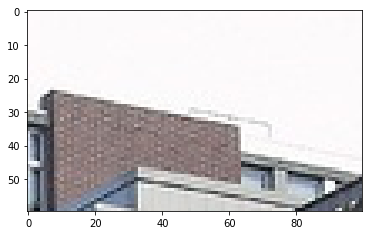

0 [[-0.0105505 -6.2860346 -5.6128407 -5.9813614 -6.0088744]]
0 [[-2.4819374e-03 -6.4952140e+00 -8.5473871e+00 -8.2254305e+00
  -7.5884862e+00]]
0 [[-0.3579595 -1.4407525 -6.2588186 -6.6709332 -2.797399 ]]
0 [[-0.49645734 -1.3059149  -6.355052   -7.689723   -2.1354053 ]]
0 [[-0.01898003 -4.256908   -5.772982   -7.5058136  -6.933238  ]]
0 [[-0.22037911 -2.2094173  -4.18025    -6.0390167  -2.654385  ]]
0 [[-0.08725071 -4.1191573  -2.8141193  -6.309434   -5.1997395 ]]
0 [[-0.02010107 -6.043269   -4.5694537  -5.905447   -5.41745   ]]
0 [[-0.04991341 -3.885273   -8.4062805  -4.9889793  -3.858015  ]]
0 [[-0.18745303 -2.3120456  -5.038264   -5.713656   -2.7792046 ]]
0 [[-0.03996038 -3.7844076  -4.8552322  -5.559959   -5.336324  ]]
0 [[-0.04705238 -3.3680162  -5.6478586  -7.0427437  -4.946849  ]]
0 [[-6.2747002e-03 -6.5694275e+00 -5.8995657e+00 -7.5056815e+00
  -6.4619360e+00]]
0 [[-0.01769972 -5.9738836  -4.3588204  -6.2470927  -8.217351  ]]
0 [[-0.00784397 -6.295773   -5.574885   -6.8859215  

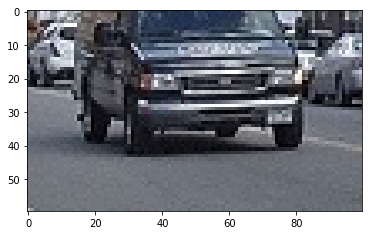

3 [[-2.487969   -1.0124551  -2.8532748  -0.76770973 -3.4462268 ]]


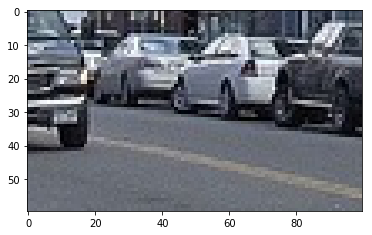

1 [[-2.2888324  -0.38662267 -3.1060786  -2.5431416  -2.344734  ]]


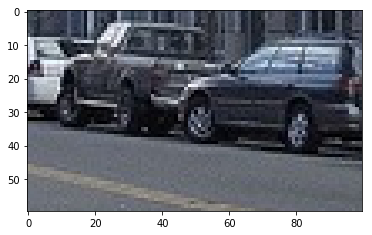

3 [[-1.2406672 -1.8898323 -2.9967976 -0.8648084 -2.4232543]]


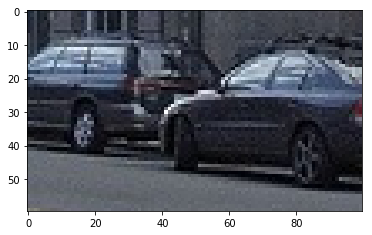

3 [[-5.2593937 -0.9078727 -5.307825  -0.7252519 -2.2801902]]


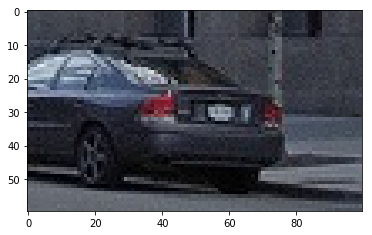

1 [[-3.9256294  -0.46269846 -4.8728104  -1.3095237  -2.6160982 ]]


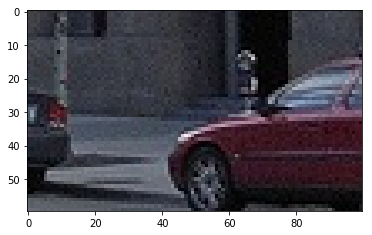

3 [[-6.2677975 -0.8904991 -7.053152  -0.5487952 -4.6947994]]


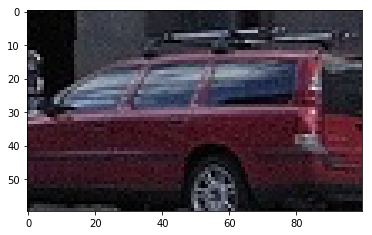

In [20]:
def sliding_predictions(image, model, winW=128, winH=128, gif_scale=0.5):
    height, width, _ = image.shape
    width_gif = int(width * gif_scale)
    height_gif = int(height * gif_scale)

    for (x, y, window) in sliding_window(image, stepSize=64, windowSize=(winW, winH)):
        # if the window does not meet our desired window size, ignore it
        if window.shape[0] != winH or window.shape[1] != winW:
            continue

        clone = image.copy()
        cropped = image[y:y + winH, x:x + winW]
        cropped = Image.fromarray(cropped)
        cropped = trans_cifar_val(cropped).unsqueeze(0)
        cropped = cropped.to(device)
        output = model(cropped).cpu().detach().numpy()
        pred = np.argmax(output)
        print(pred, output)
        if pred != 0:
            plt.imshow(image[y:y + winH, x:x + winW])
            plt.show()

winW = 100
winH = 60
sliding_predictions(image, model, winW=winW, winH=winH)